In [1]:
import numpy as np  # always need it
import matplotlib.pyplot as plot
import skimage
import ot  # ot
import pandas as pd

In [25]:
df = pd.read_csv("/Users/andrewrodriguez/Desktop/Files/OT_Testing/sample_data.csv")
df["x"] = ((df["x"] + 1) * 50) 
df["y"] = ((df["y"] + 1) * 50) 
df = df[["x", "y", "t_ind"]]

In [26]:
df.tail()

,x,y,t_ind
2372,64.648154,46.302953,10
2373,57.299726,31.786877,10
2374,49.358197,58.576153,10
2375,44.871556,45.205018,10
2376,47.323196,52.366679,10


In [27]:
time_set = []

for time in df["t_ind"].unique():
    this_time = df[df["t_ind"] == time]
    coords = this_time[['x', 'y']].values
    time_set.append(coords)

In [28]:
map_dim = 100
time_maps = []

for set in time_set:
    density_map = np.zeros((map_dim, map_dim))
    cell_coords = np.int64(set)
    current_cells = cell_coords
    n_cells = current_cells.shape[0]
    prop = np.ones(n_cells)  # just cell density

        
    # Populate the map with cell densities
    for idx in range(n_cells):
        density_map[cell_coords[idx, 1], cell_coords[idx, 0]] += prop[idx]

    sigma_pix = 1
    density_map = skimage.filters.gaussian(density_map, sigma=sigma_pix, truncate=1) 

    time_maps.append(density_map)


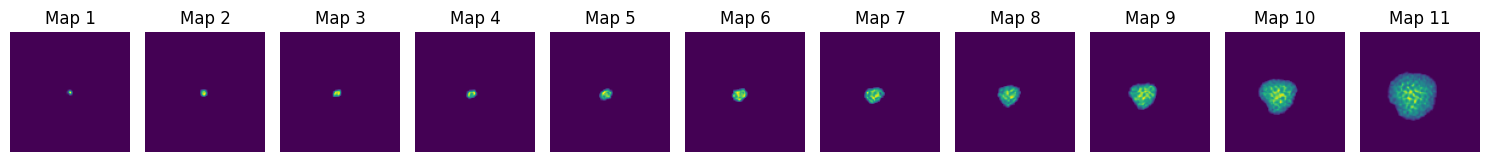

In [29]:
fig, axes = plot.subplots(1, len(time_maps), figsize=(15, 5))  # Adjust figsize as needed

for i, (ax, map) in enumerate(zip(axes, time_maps)):
    ax.imshow(map.T)
    ax.set_title(f'Map {i+1}')  # Set label for each subplot
    ax.axis('off')  # Turn off axis if not needed

plot.tight_layout()
plot.show()

In [30]:
points = []

for i in range(map_dim):
    for j in range(map_dim):
        points.append([i,j])

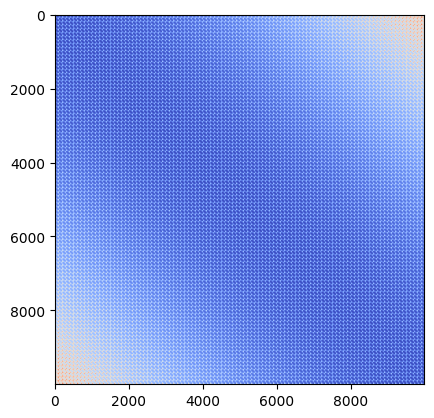

In [31]:
C = ot.dist(np.array(points), np.array(points))


im = plot.imshow(C, cmap="coolwarm")


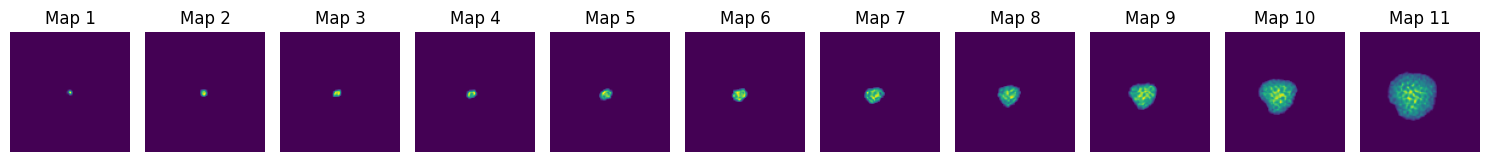

In [32]:
fig, axes = plot.subplots(1, len(time_maps), figsize=(15, 5))  # Adjust figsize as needed

for i, (ax, map) in enumerate(zip(axes, time_maps)):
    ax.imshow(map.T)
    ax.set_title(f'Map {i+1}')  # Set label for each subplot
    ax.axis('off')  # Turn off axis if not needed

plot.tight_layout()
plot.show()

running OT
OT ran
running OT
OT ran
running OT
OT ran
running OT
OT ran
running OT
OT ran
running OT
OT ran
running OT
OT ran
running OT
OT ran
running OT
OT ran
running OT
OT ran


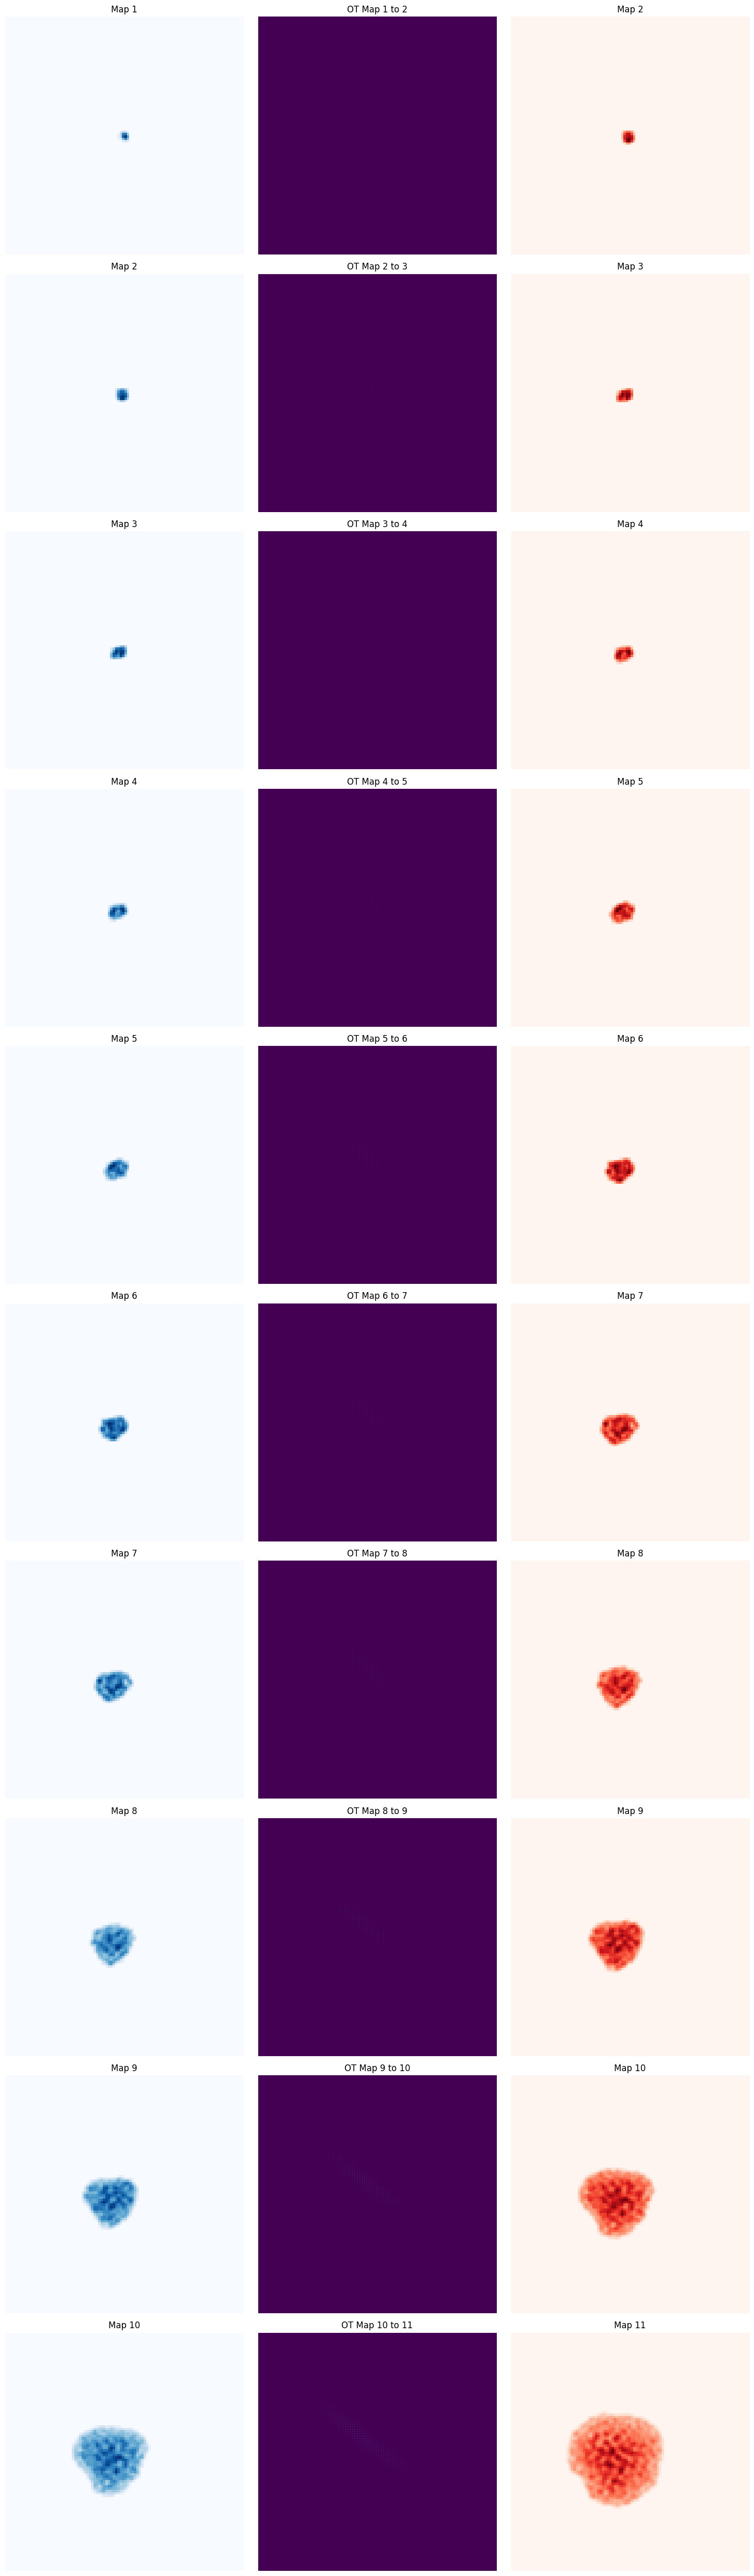

In [34]:
import numpy as np
import ot
import matplotlib.pyplot as plt

# Sample time_maps (replace with your actual data)
# Create a figure with subplots arranged side by side
fig, axes = plt.subplots(len(time_maps) - 1, 3, figsize=(15, 5 * (len(time_maps) - 1)))

sk = []

for i in range(len(time_maps) - 1):
    map1 = time_maps[i+1].astype(np.float64)  # Convert to float64 for OT computation
    map2 = time_maps[i].astype(np.float64)

    # Flatten the maps to 1D arrays
    map1_flat = map1.flatten()
    map2_flat = map2.flatten()

    reg = 0.001
    K = np.exp(-C / C.max() / reg)
    nit = 100

    print("running OT")
    u = np.ones(len(map1_flat), )
    for j in range(1, nit):
        v = map2_flat / np.dot(K.T, u)
        u = map1_flat / (np.dot(K, v))
    ot_sink_algo = np.atleast_2d(u).T * (K * v.T)  # Equivalent to np.dot(np.diag(u), np.dot(K, np.diag(v)))
    print("OT ran")

    nx, ny = map1.shape
    X, Y = np.meshgrid(np.arange(nx), np.arange(ny))
    pos = np.vstack([X.ravel(), Y.ravel()]).T
    cost_matrix = ot.dist(pos, pos)

    # Reshape the OT matrix back to the original map shape
    ot_map = ot_sink_algo.reshape(nx, ny, nx, ny).sum(axis=2).sum(axis=2)

    # Plot the first density map
    ax1 = axes[i, 2]
    im1 = ax1.imshow(map1.T, cmap='Reds')
    ax1.set_title(f'Map {i+2}')
    ax1.axis('off')

    # Plot the second density map
    ax2 = axes[i, 0]
    im2 = ax2.imshow(map2.T, cmap='Blues')
    ax2.set_title(f'Map {i+1}')
    ax2.axis('off')

    # Plot the OT map
    ax3 = axes[i, 1]
    im3 = ax3.imshow(ot_sink_algo.T, cmap='viridis')
    ax3.set_title(f'OT Map {i+1} to {i+2}')
    ax3.axis('off')

    sk.append(ot_sink_algo)


plt.tight_layout()
plt.show()

In [35]:
chains = [] 
gens_back = len(sk)-1
parent_matrix = np.array(sk[len(sk)-1])
print("Chaining")
for i in range (gens_back):
    print(f"Running {i+1} gens back")
    chains.append(parent_matrix)
    child_matrix = np.array(sk[len(sk)-(i+2)])
    # New parent matrix becomes the result of the mat mul
    parent_matrix = np.matmul(parent_matrix, child_matrix)
# For more reading on why this math works, look up Markov chains
chains.append(parent_matrix)
final = parent_matrix

Chaining
Running 1 gens back
Running 2 gens back
Running 3 gens back
Running 4 gens back
Running 5 gens back
Running 6 gens back
Running 7 gens back
Running 8 gens back
Running 9 gens back


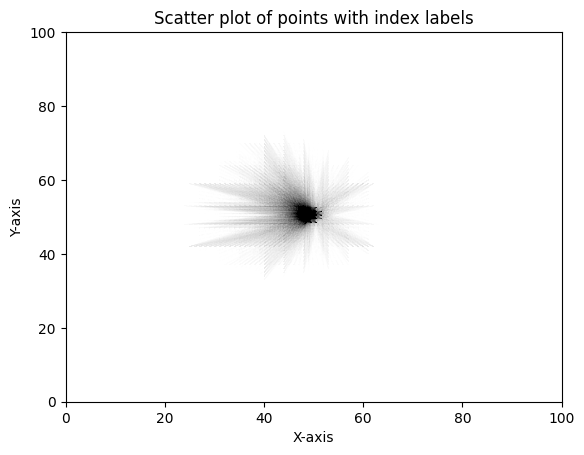

In [39]:
# Scatter plot for shifted points (red)
shifted_points = [(point[0] + 0.5, point[1] + 0.5) for point in points]

# Draw lines representing OT transport
for i in range(len(points)):
    for j in range(len(shifted_points)):
        if final[i, j] > 0:
            plt.plot([points[i][0], shifted_points[j][0]], [points[i][1], shifted_points[j][1]], 'k-', alpha=0.5, lw = 5*final[i, j])


# Add labels and title
plt.xlim(0,100)
plt.ylim(0,100)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter plot of points with index labels')

plt.show()